# Ensembling Models

The following is a brief demonstration of the ensemble models in darts. Starting from the examples provided in the [Quickstart Notebook](https://unit8co.github.io/darts/quickstart/00-quickstart.html), some advanced features and subtilities will be detailed.

The following topics are covered in this notebook :
* [Basics & references](#Basics-&-references)
* [Naive ensembling](#naive-ensembling)
    * [Deterministic](#naive-ensembling)
    * [Probabilistic](#probabilistic-naive-ensembling)
* [Learned ensembling](#learned-ensembling)
    * [Deterministic](#learned-ensembling)
    * [Probabilistic](#probabilistic-regression-ensemble)
    * [Bootstraping](#bootstrapping-regression-ensemble)
* [Pre-trained Ensembling](#pre-trained-ensembling)

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveEnsembleModel,
    LinearRegressionModel,
    RegressionEnsembleModel,
    NaiveDrift,
    NaiveSeasonal,
    TFTModel,
    ExponentialSmoothing,
    KalmanForecaster,
    XGBModel,
)
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.utils.timeseries_generation import linear_timeseries
from darts.dataprocessing.transformers import Scaler

import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)

## Basics & references

Ensembling consists in combining several "weak" models forecasts to obtain a more robust and accurate model.

All the ensembling models in darts are inheriting from the `EnsembleModel` class and rely on the **stacking technique** ([reference](https://machinelearningmastery.com/essence-of-stacking-ensembles-for-machine-learning/)). They provide the same functionnalities as the other forecasting models, meaning that depending on the ensembled models, they can also use covariates, be trained on multiple-series or predict multivariate targets.

## Preparing the dataset
Here we simply read the CSV file containing daily temperatures, and transform the values into a `TimeSeries`.

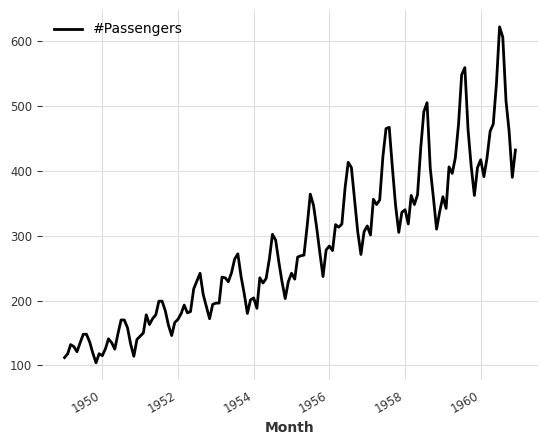

In [3]:
ts_air = AirPassengersDataset().load()
ts_air.plot()
plt.show()

## Naive ensembling

Naive ensembling consists in averaging the forecasts generated by several models. Darts provide the `NaiveEnsembleModel` class which accept both `Local` and `Global` forecasting models (as well as combination of the two, with some additional limitations).

NaiveEnsemble (naive) MAPE: 11.87818


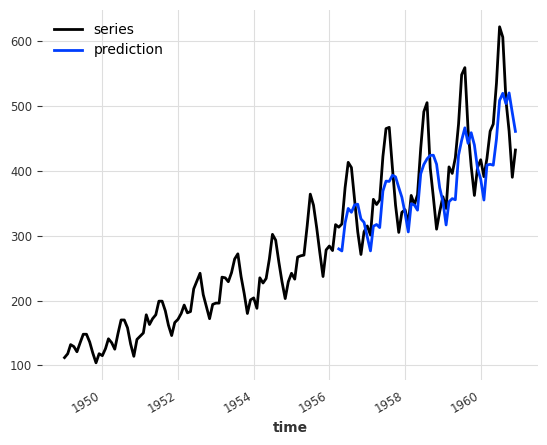

In [4]:
naive_ensemble = NaiveEnsembleModel([NaiveSeasonal(K=12), NaiveDrift()])

backtest = naive_ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot(label="series")
backtest.plot(label="prediction")
print("NaiveEnsemble (naive) MAPE:", round(mape(backtest, ts_air), 5))

**Note**: after looking at the each model's MAPE, one would notice that `NaiveSeasonal` is actually performing better on its own that ensembled with `NaiveDrift`. Checking the performance of simple models and the overall appearance of their forecasts is in general a good practice before defining an ensemble.

Before creating the new `NaiveEnsemble`, we will screen models to identify which ones would do well together. The candidates are : 
- `LinearRegressionModel` : classic and simple model
- `ExponentialSmoothing` : moving window model
- `FalmanForecaster` : a filter-based model
- `XGBModel` : decision trees model

In [5]:
lin_reg = LinearRegressionModel(lags=12)
backtest_linreg = lin_reg.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)
print("LinearRegression MAPE:", round(mape(backtest_linreg, ts_air), 5))
exp_smo = ExponentialSmoothing()
backtest_expsmo = exp_smo.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)
print("ExponentialSmoothing MAPE:", round(mape(backtest_expsmo, ts_air), 5))
kalman = KalmanForecaster(dim_x=12)
backtest_kalman = kalman.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)
print("KalmanForecaster MAPE:", round(mape(backtest_kalman, ts_air), 5))
xgboost = XGBModel(lags=12)
backtest_xgboost = xgboost.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)
print("XGBModel MAPE:", round(mape(backtest_xgboost, ts_air), 5))

LinearRegression MAPE: 4.64008
ExponentialSmoothing MAPE: 4.44874
KalmanForecaster MAPE: 4.5539
XGBModel MAPE: 6.86685


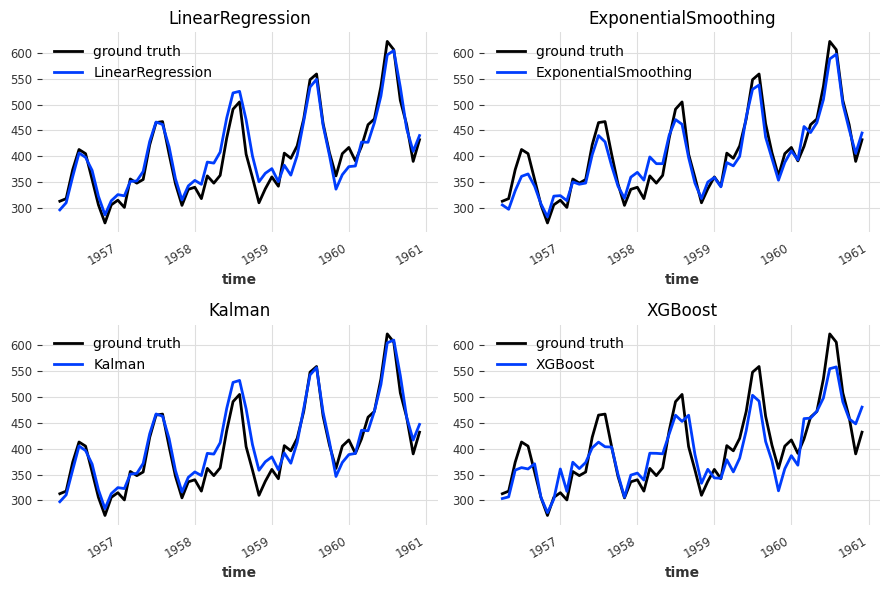

In [6]:
fix, axes = plt.subplots(2, 2, figsize=(9, 6))
for ax, backtest, model_name in zip(
    axes.flatten(),
    [backtest_linreg, backtest_expsmo, backtest_kalman, backtest_xgboost],
    ["LinearRegression", "ExponentialSmoothing", "Kalman", "XGBoost"],
):
    ts_air[-len(backtest) :].plot(ax=ax, label="ground truth")
    backtest.plot(ax=ax, label=model_name)

    ax.set_title(model_name)
plt.tight_layout()

The historical forecasts obtained with the `LinearRegressionModel` and `KalmanForecaster` look quite similar whereas `ExponentialSmoothing` and `XGBModel`'s tend to understimate the true values. To benefits from the ensemble, we will favor diversity and continue with the `LinearRegressionModel` and `ExponentialSmoothing`.

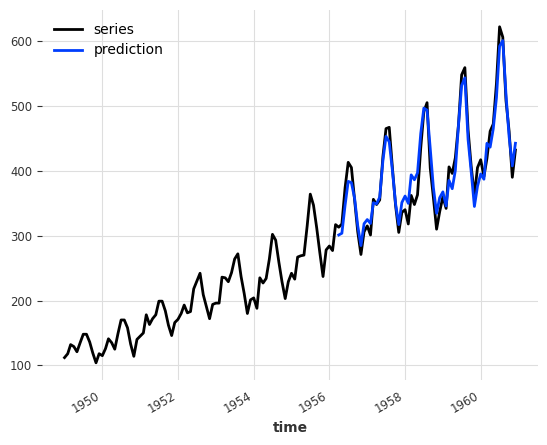

NaiveEnsemble (v2) MAPE: 4.04297


In [7]:
ensemble = NaiveEnsembleModel(forecasting_models=[lin_reg, exp_smo])

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot(label="series")
backtest.plot(label="prediction")
plt.show()
print("NaiveEnsemble (v2) MAPE:", round(mape(backtest, ts_air), 5))

Compared to the individual model MAPE score, 4.64008 for the `LinearRegressionModel` and 4.44874 for the `ExponentialSmoothing`, the ensembling improved the accuracy to 4.04297!


### Using covariates & predicting multivariate series

Depending on the forecasting models used, the `EnsembleModel` can of course also leverage covariates or forecast multivariates series!

In [8]:
ensemble = NaiveEnsembleModel(
    [LinearRegressionModel(lags=12, lags_past_covariates=6), ExponentialSmoothing()]
)





### Probabilistic naive ensembling

Combining models supporting probabilistic forecasts results in a probabilistic `NaiveEnsemble`! We can easily tweak the models used above to make them probabilistic and obtain confidence interval in ours forecasts:

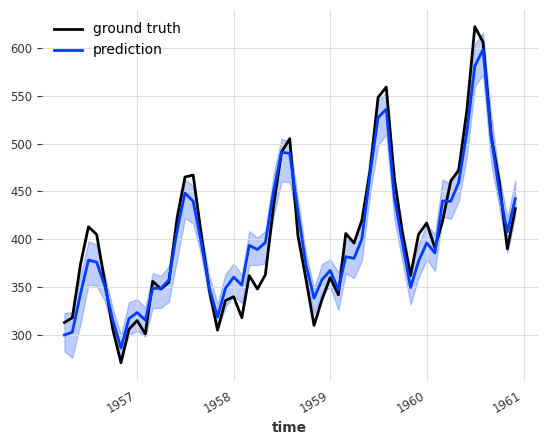

In [9]:
ensemble_probabilistic = NaiveEnsembleModel(
    forecasting_models=[
        LinearRegressionModel(
            lags=12,
            likelihood="quantile",
            quantiles=[0.05, 0.5, 0.95],
        ),
        ExponentialSmoothing(),
    ]
)

backtest = ensemble_probabilistic.historical_forecasts(
    ts_air, start=0.6, forecast_horizon=3, num_samples=100
)

ts_air[-len(backtest) :].plot(label="ground truth")
backtest.plot(label="prediction")
plt.show()

## Learned ensembling

Ensembling can also be considered as a supervised regression problem: given a set of forecasts (features), find a model that combines them in order to minimise errors on the target.
This is what the `RegressionEnsembleModel` does. It accepts three parameters:

* `forecasting_models` is a list of forecasting models whose predictions we want to ensemble.
* `regression_train_n_points` is the number of time steps to use for fitting the "ensemble regression" model (i.e., the inner model that combines the forecasts).
* `regression_model` is, optionally, a sklearn-compatible regression model or a Darts `RegressionModel` to be used for the ensemble regression. If not specified, a linear regression is used. Using a sklearn model is easy out-of-the-box, but using a `RegressionModel` allows to potentially take arbitrary lags of the individual forecasts as inputs of the regression model.

Once these elements are in place, a `RegressionEnsembleModel` can be used like a regular forecasting model:

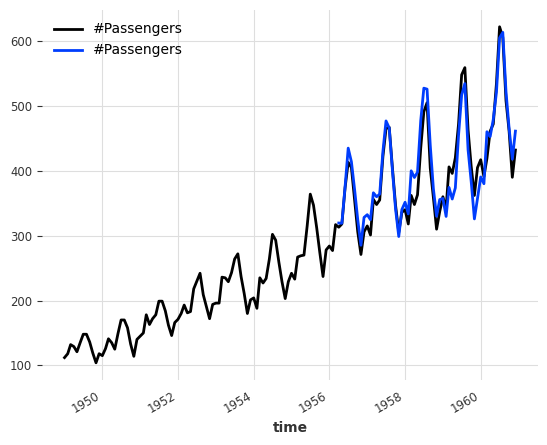

RegressionEnsemble (naive) MAPE: 4.85142


In [10]:
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(K=12), NaiveDrift()],
    regression_train_n_points=12,
)

backtest = ensemble_model.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot()
backtest.plot()
plt.show()

print("RegressionEnsemble (naive) MAPE:", round(mape(backtest, ts_air), 5))

Compared to the MAPE of 11.87818 obtained at the beginning of the [naive ensembling section](#Naive-ensembling), adding a `LinearRegressionModel` on top of the two naive models does improve the quality of the forecast.

Now, let's see if we can observe similar gain when the `RegressionEnsemble` forecasting models are not naive:

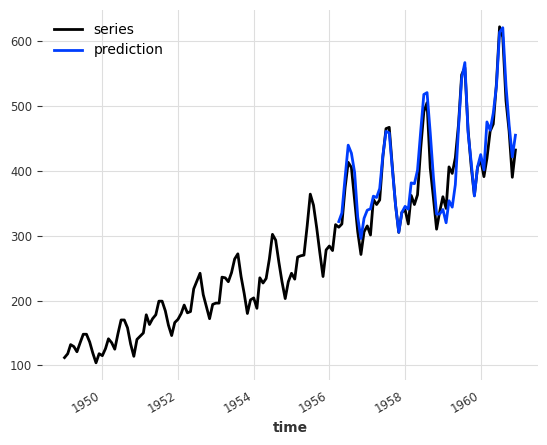

RegressionEnsemble (v2) MAPE: 4.63334


In [11]:
ensemble = RegressionEnsembleModel(
    forecasting_models=[lin_reg, exp_smo], regression_train_n_points=12
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air.plot(label="series")
backtest.plot(label="prediction")
plt.show()
print("RegressionEnsemble (v2) MAPE:", round(mape(backtest, ts_air), 5))

Interestingly, even if the MAPE improved compared to the `RegressionEnsemble` relying on naive models (MAPE: 4.85142), it does not outperform the `NaiveEnsemble` using similar forecasting models (MAPE: 4.04297). 

This performance gap is partially caused by the points set aside to train the ensembling `LinearRegression`; the two forecasting models (`LinearRegression` and `ExponentialSmoothing`) cannot access the latest values of the series, which present an marked upward trend.

Out of curiosity, we can use the `Ridge` regression model from the sklearn library to ensemble the forecasts:

In [12]:
from sklearn.linear_model import Ridge

ensemble = RegressionEnsembleModel(
    forecasting_models=[lin_reg, exp_smo],
    regression_train_n_points=12,
    regression_model=Ridge(),
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

print("RegressionEnsemble (Ridge) MAPE:", round(mape(backtest, ts_air), 5))

RegressionEnsemble (Ridge) MAPE: 6.46803


In this particuliar scenario, using a regression model with a regularization term sligthly deteriorated the forecasts but there might be other cases where it could considerably improve them.

### Probabilistic regression ensemble

In order to be probabilistic, the `RegressionEnsembleModel`, must have a probabilistic ensembling regression model (see table in the README):

RegressionEnsemble (probabilistic) MAPE: 5.3815


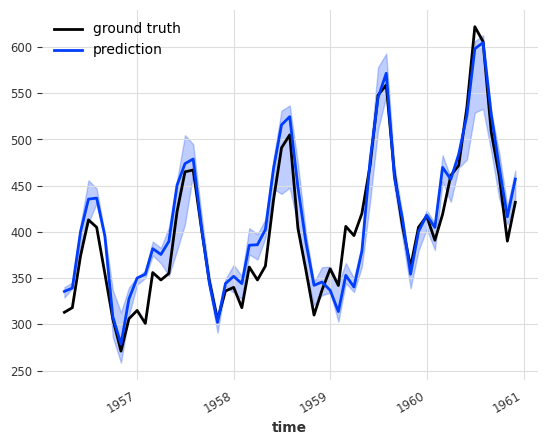

In [13]:
ensemble = RegressionEnsembleModel(
    forecasting_models=[lin_reg, exp_smo],
    regression_train_n_points=12,
    regression_model=LinearRegressionModel(
        lags_future_covariates=[0], likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
    ),
)

backtest = ensemble.historical_forecasts(
    ts_air, start=0.6, forecast_horizon=3, num_samples=100
)

print("RegressionEnsemble (probabilistic) MAPE:", round(mape(backtest, ts_air), 5))

ts_air[-len(backtest) :].plot(label="ground truth")
backtest.plot(label="prediction")
plt.show()

### Bootstrapping regression ensemble

When the forecasting models of a `RegressionEnsembleModel` are probabilistic, the samples dimension of their forecasts is reduced and used as covariates for the ensembling regression. Since the ensembling regression model is deterministic, the generated forecasts is deterministic as well.

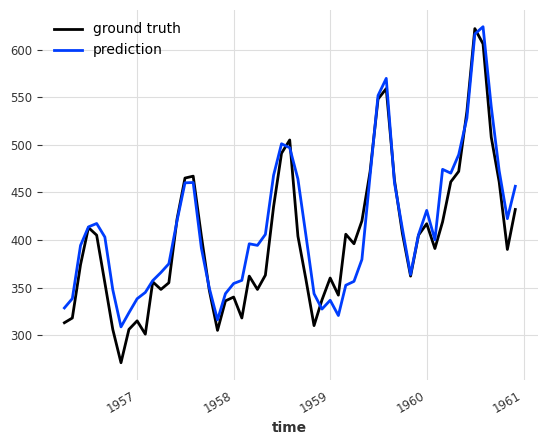

RegressionEnsemble (bootstrap) MAPE: 5.30675


In [14]:
ensemble = RegressionEnsembleModel(
    forecasting_models=[
        LinearRegressionModel(
            lags=12, likelihood="quantile", quantiles=[0.05, 0.5, 0.95]
        ),
        ExponentialSmoothing(),
    ],
    regression_train_n_points=12,
    regression_train_num_samples=100,
    regression_train_samples_reduction="median",
)

backtest = ensemble.historical_forecasts(ts_air, start=0.6, forecast_horizon=3)

ts_air[-len(backtest) :].plot(label="ground truth")
backtest.plot(label="prediction")
plt.show()

print("RegressionEnsemble (bootstrap) MAPE:", round(mape(backtest, ts_air), 5))

### Pre-trained ensembling

As both `NaiveEnsembleModel` and `RegressionEnsembleModel` accept `GlobalForecastingModel` as forecasting models, they can be used to ensemble pre-trained deep learning models (pre-trained regression models are also supported but since their training is in general less time consumming, the advantages are limited). Note that this functionnality is only supported if all the ensembled forecasting models are instances from the `GlobalForecastingModel` class and are already trained when creating the ensemble.

**Disclaimer** : Be careful not to pre-train the models with data used during validation as this would introduce considerable bias.

**Note** : The training procedure for the `TFTModel` is heavily inspired from the [TFTModel example notebook](https://unit8co.github.io/darts/examples/13-TFT-examples.html).

In [15]:
# convert from monthly number of passengers to average daily number of passengers per month
ts_air = ts_air / TimeSeries.from_series(ts_air.time_index.days_in_month)
# holding out values for validation
train, val = ts_air.split_after(0.8)

# scaling the target
scaler = Scaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)

# creating future covariates based on the time index
future_covs = dt_attr(ts_air, attribute="year", add_length=24)
future_covs = future_covs.stack(dt_attr(ts_air, attribute="month", add_length=24))
future_covs = future_covs.stack(
    linear_timeseries(
        start_value=0,
        end_value=len(future_covs),
        start=future_covs.start_time(),
        end=future_covs.end_time(),
        freq=future_covs.freq,
    )
)

# scaling the future covariates
scaler_covs = Scaler()
train_covs, val_covs = future_covs.split_after(train.end_time())
scaler_covs.fit(train_covs)
future_covs = scaler_covs.transform(future_covs)

# training a regular linear regression, without any covariates
linreg_model = LinearRegressionModel(lags=24)
linreg_model.fit(train)

# instanciating a TFT model with parameters optimized for the AirPassenger dataset
tft_model = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
)
tft_model.fit(train, future_covariates=future_covs)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300)

As a sanity check, we will look at the forecast of the model taken individually:

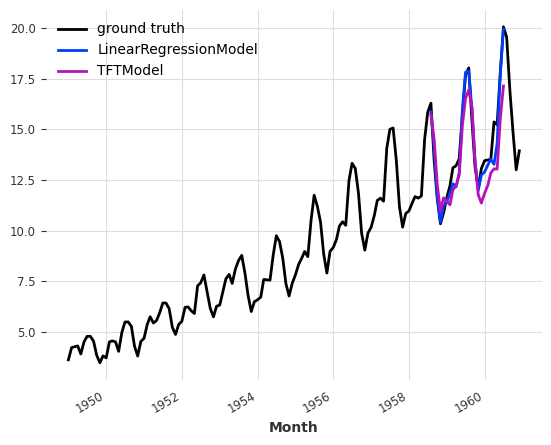

In [16]:
# individual model forecasts
pred_linreg = linreg_model.predict(24)
pred_tft = tft_model.predict(24, verbose=False)

# scaling them back
pred_linreg_rescaled = scaler.inverse_transform(pred_linreg)
pred_tft_rescaled = scaler.inverse_transform(pred_tft)

# plotting
ts_air.plot(label="ground truth")
pred_linreg_rescaled.plot(label="LinearRegressionModel")
pred_tft_rescaled.plot(label="TFTModel")
plt.show()

Now that we have a good idea of the individual performance of each of these models, we can ensemble them. We must make sure to set `retrain_forecasting_models=False` or the ensemble will need to be fitted before being able to call `predict()`.

**Advice** : Use the `save()` method to export your model and keep a copy of your weights.

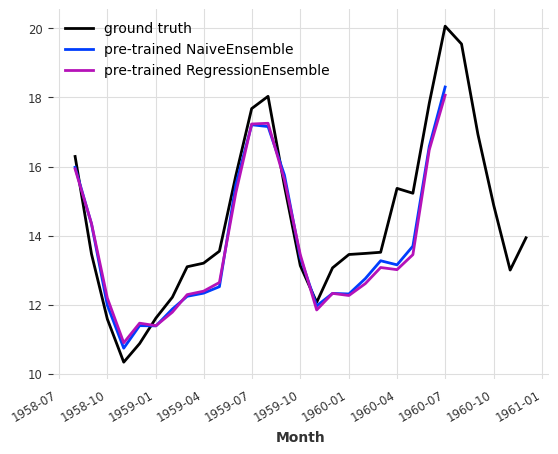

TFTModel MAPE: 8.2586
NaiveEnsemble (pre-trained) MAPE: 5.37899
RegressionEnsemble (pre-trained) MAPE: 5.91535


In [17]:
naive_ensemble = NaiveEnsembleModel(
    forecasting_models=[tft_model, linreg_model], retrain_forecasting_models=False
)
# NaiveEnsemble initialized with pre-trained models can call predict() directly,
# the `series` argument must however be provided
pred_naive = naive_ensemble.predict(24, train)

pretrain_ensemble = RegressionEnsembleModel(
    forecasting_models=[tft_model, linreg_model],
    regression_train_n_points=24,
    retrain_forecasting_models=False,
)
# RegressionEnsemble must train the regression model, even if the forecasting models are already trained
pretrain_ensemble.fit(train)
pred_ens = pretrain_ensemble.predict(24)

# scaling back the predictions
pred_naive_rescaled = scaler.inverse_transform(pred_naive)
pred_ens_rescaled = scaler.inverse_transform(pred_ens)

# plotting
scaler.inverse_transform(val).plot(label="ground truth")
pred_naive_rescaled.plot(label="pre-trained NaiveEnsemble")
pred_ens_rescaled.plot(label="pre-trained RegressionEnsemble")
plt.show()

# MAPE
print("TFTModel MAPE:", round(mape(pred_tft_rescaled, ts_air), 5))
print("NaiveEnsemble (pre-trained) MAPE:", round(mape(pred_naive_rescaled, ts_air), 5))
print(
    "RegressionEnsemble (pre-trained) MAPE:", round(mape(pred_ens_rescaled, ts_air), 5)
)

## Conclusion

Due to the size of the dataset, the `NaiveEnsemble` outperforms both the `TFTModel` and the `RegressionEnsemble` (as observed at the end of the [learned ensembling section](#learned-ensembling)), making the results of this example a bit underwhelming. 

However, ensembling is a powerful technique that can yield impressive results and was notably used by the winners of the 4th edition of the Makridakis Competition ([website](https://mofc.unic.ac.cy/history-of-competitions/), [github repository](https://github.com/Mcompetitions/)).